In [64]:
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
from datetime import datetime

from shapely import geometry

import json 

%matplotlib inline

In [ ]:
date.fromtimestamp()

# 2019 Location History – Google

In [178]:
%%bash 
cat 2019_*.json | jq '.timelineObjects[] | if .placeVisit then {type: "placevisit", location: {latE7: .placeVisit.centerLatE7, lonE7: .placeVisit.centerLngE7}, duration: .placeVisit.duration} else {type: "move", location: .activitySegment.waypointPath.waypoints, duration: .activitySegment.duration} end'  > combined.json

cat: 2019_*.json: No such file or directory


In [179]:
data = json_normalize(json.load(open("Location History/Semantic Location History/2019/combined.json")))

In [180]:
data['duration.endTimestampMs'] = [datetime.fromtimestamp(int(d) // 1000) for d in data['duration.endTimestampMs'].values]
data['duration.startTimestampMs'] = [datetime.fromtimestamp(int(d) // 1000) for d in data['duration.startTimestampMs'].values]
data = data.rename(index=str, columns={"duration.endTimestampMs": 'endTime', "duration.startTimestampMs": 'startTime'})

In [181]:
data.head()

,endTime,startTime,location,location.latE7,location.lonE7,type
0,2019-03-31 22:10:35,2019-03-31 20:12:37,"[{'latE7': 476625556, 'lngE7': -1223608627}, {...",NaN,NaN,move
1,2019-03-31 22:39:43,2019-03-31 22:10:35,NaN,476239200.0,-1.223015e+09,placevisit
2,2019-03-31 22:46:39,2019-03-31 22:39:43,"[{'latE7': 476243934, 'lngE7': -1223012008}, {...",NaN,NaN,move
3,2019-03-31 22:59:38,2019-03-31 22:46:39,NaN,475998500.0,-1.223010e+09,placevisit
4,2019-04-01 10:26:40,2019-03-31 22:59:38,"[{'latE7': 476002464, 'lngE7': -1222998657}, {...",NaN,NaN,move


In [182]:
pointlocs = data[data.type == 'placevisit']
pointlocs
lat_lon = [ {'lon': i[1], 'lat' : i[0]} for i in zip(pointlocs['location.latE7'], pointlocs['location.lonE7'])]
pointlocs.location = lat_lon

/Users/tony/miniconda3/envs/geo/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [183]:
data.loc[pointlocs.index, 'location']= lat_lon

In [184]:
data = data.drop(['location.latE7', 'location.lonE7'], axis=1)

In [185]:
data.head()

,endTime,startTime,location,type
0,2019-03-31 22:10:35,2019-03-31 20:12:37,"[{'latE7': 476625556, 'lngE7': -1223608627}, {...",move
1,2019-03-31 22:39:43,2019-03-31 22:10:35,"{'lon': -1223014800.0, 'lat': 476239200.0}",placevisit
2,2019-03-31 22:46:39,2019-03-31 22:39:43,"[{'latE7': 476243934, 'lngE7': -1223012008}, {...",move
3,2019-03-31 22:59:38,2019-03-31 22:46:39,"{'lon': -1223010450.0, 'lat': 475998500.0}",placevisit
4,2019-04-01 10:26:40,2019-03-31 22:59:38,"[{'latE7': 476002464, 'lngE7': -1222998657}, {...",move


In [186]:
def convert_location_list(loclist):
    if loclist:
        ret = []
        for loc in loclist:
            ret.append({
                k.replace("E7", ""): v / 10**7
                for k, v in loc.items()
            })
    #     return ret
        return geometry.LineString([geometry.Point(i['lng'], i['lat']) for i in ret])
    else :
        return loclist
        
def convert_point(point):
    if point:
        return geometry.Point(point['lon'] / 10**7, point['lat'] / 10**7)
    else :
        return point

In [187]:
converted_locs = [convert_location_list(i.location) if i.type =='move' else convert_point(i.location) for _, i in data.iterrows()]

In [188]:
data.location = converted_locs

In [189]:
data.head()

,endTime,startTime,location,type
0,2019-03-31 22:10:35,2019-03-31 20:12:37,"LINESTRING (-122.3608627 47.6625556, -122.3609...",move
1,2019-03-31 22:39:43,2019-03-31 22:10:35,POINT (-122.30148 47.62392),placevisit
2,2019-03-31 22:46:39,2019-03-31 22:39:43,"LINESTRING (-122.3012008 47.6243934, -122.3024...",move
3,2019-03-31 22:59:38,2019-03-31 22:46:39,POINT (-122.301045 47.59985),placevisit
4,2019-04-01 10:26:40,2019-03-31 22:59:38,"LINESTRING (-122.2998657 47.6002464, -122.3472...",move


In [190]:
data_geo = gpd.GeoDataFrame(data, geometry=data.location)

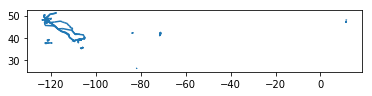

In [198]:
data_geo[data_geo['type'] == 'move'].plot()

## Try to use raw location data

In [244]:
rawdata = "Location History/Location History.json"
raw = json_normalize(json.load(open(rawdata))['locations'])

In [245]:
raw['time'] = [datetime.fromtimestamp(int(i.timestampMs) // 1000) for _, i in raw.iterrows()]

In [246]:
raw_2019 = raw[raw.time > '2019-01-01']

In [247]:
raw_2019 =  raw_2019.set_index(raw_2019.time)

In [248]:
raw_2019.head()

,accuracy,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,time
time,,,,,,,,,
2019-01-01 10:50:06,10,132.0,NaN,485310797,-1214493634,1546357806916,NaN,24.0,2019-01-01 10:50:06
2019-01-01 11:12:26,10,107.0,NaN,485312593,-1214496719,1546359146258,0.0,4.0,2019-01-01 11:12:26
2019-01-01 11:16:49,10,12.0,NaN,485311283,-1214494366,1546359409220,0.0,32.0,2019-01-01 11:16:49
2019-01-01 11:34:58,10,87.0,NaN,485311578,-1214495411,1546360498813,0.0,24.0,2019-01-01 11:34:58
2019-01-01 11:54:55,10,123.0,25.0,485312254,-1214496973,1546361695866,0.0,16.0,2019-01-01 11:54:55


In [249]:
def group_linestring(group):
    try:
        return geometry.LineString(list(zip(group.longitudeE7 / 10**7, group.latitudeE7 / 10**7)))
    except Exception as e:
        return None



In [257]:
ans = raw_2019.groupby(pd.Grouper(freq='D')).apply(group_linestring)

In [263]:
gpd.GeoSeries(ans).to_file('2019_paths.geojson', driver="GeoJSON")

In [274]:
geo_raw = gpd.GeoSeries(ans)

In [276]:
geo_raw.index = geo_raw.index.strftime("%Y-%m-%d")

In [278]:
geo_raw.to_file("2019_paths.shp")